In [25]:
import cv2
import numpy as np
import mediapipe as mp
import requests  
from PIL import Image
import matplotlib.pyplot as plt

In [26]:
# source 이미지, destination 이미지 불러오기
image1 = cv2.imread('img_data/source.png')
image2 = cv2.imread('img_data/destination.png')
image1 = image1[:,:, ::-1]
image2 = image2[:,:, ::-1]

In [27]:
# 얼굴 특징점 검출기 정의 
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

In [28]:
# 이미지를 array로 변환 후, grayscale (1차원) 변환
img = np.array(image1)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
mask = np.zeros_like(img_gray)
img2 = np.array(image2)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
# mask2 = np.zeros_like(img2_gray)

In [29]:
height, width, channels = img2.shape
img2_new_face = np.zeros((height, width, channels), np.uint8)

In [30]:
# index array에서 0번째 값 반환
def extract_index_nparray(nparray):
    index = None
    for num in nparray[0]:
        index = num
        break
    return index

1


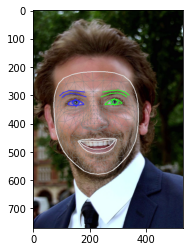

In [31]:
# source 얼굴 특징점 검출
with mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5) as face_mesh:

    # Convert the BGR image to RGB before processing.
    results = face_mesh.process(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
    # Print and draw face mesh landmarks on the image.
    annotated_image = image1.copy()
    for face_landmarks in results.multi_face_landmarks:
        print(len(results.multi_face_landmarks))
        landmarks_points = []
        for n in range(0, 468):
            x = int(face_landmarks.landmark[n].x * image1.shape[1])
            y = int(face_landmarks.landmark[n].y * image1.shape[0])
            landmarks_points.append((x,y))
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_tesselation_style())
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_contours_style())
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_IRISES,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_iris_connections_style())
        plt.imshow(annotated_image)

        
        points = np.array(landmarks_points, np.int32)
        
        # 얼굴 특징점 경계선 추출
        convexhull = cv2.convexHull(points)
        cv2.fillConvexPoly(mask, convexhull, 255)
#         plt.imshow(mask)
        
        # 얼굴 특징점 경계선을 따라 얼굴 이미지 추출
        face_image_1 = cv2.bitwise_and(img, img, mask=mask)

        # source 얼굴 들로네 삼각망 구축
        rect = cv2.boundingRect(convexhull)
        subdiv = cv2.Subdiv2D(rect)
        subdiv.insert(landmarks_points)
        triangles = subdiv.getTriangleList()
        triangles = np.array(triangles, dtype=np.int32)
        
        # 들로네 삼각망의 triangles 인덱스 구하기 
        indexes_triangles = []
        for t in triangles:
            pt1 = (t[0], t[1])
            pt2 = (t[2], t[3])
            pt3 = (t[4], t[5])
    
    
            index_pt1 = np.where((points == pt1).all(axis=1))
            index_pt1 = extract_index_nparray(index_pt1)
    
            index_pt2 = np.where((points == pt2).all(axis=1))
            index_pt2 = extract_index_nparray(index_pt2)
    
            index_pt3 = np.where((points == pt3).all(axis=1))
            index_pt3 = extract_index_nparray(index_pt3)
    
            if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
                triangle = [index_pt1, index_pt2, index_pt3]
                indexes_triangles.append(triangle)

1


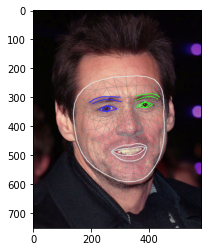

In [32]:
# destination 얼굴 특징점 검출
with mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5) as face_mesh:

    # Convert the BGR image to RGB before processing.
    results = face_mesh.process(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
    # Print and draw face mesh landmarks on the image.
    annotated_image = image2.copy()
    for face_landmarks in results.multi_face_landmarks:
        print(len(results.multi_face_landmarks))
        landmarks_points2 = []
        for n in range(0, 468):
            x = int(face_landmarks.landmark[n].x * image2.shape[1])
            y = int(face_landmarks.landmark[n].y * image2.shape[0])
            landmarks_points2.append((x,y))
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_tesselation_style())
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_contours_style())
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_IRISES,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_iris_connections_style())
        plt.imshow(annotated_image)

        
        points2 = np.array(landmarks_points2, np.int32)
        
        # 얼굴 특징점 경계선 추출
        convexhull2 = cv2.convexHull(points2)
        cv2.fillConvexPoly(mask2, convexhull2, 255)
#         plt.imshow(mask2)

In [33]:
lines_space_mask = np.zeros_like(img_gray)
lines_space_new_face = np.zeros_like(img2)

In [34]:
# source 얼굴 들로네 삼각망을 destination 얼굴 들로네 삼각망 일치하도록 변형
for triangle_index in indexes_triangles:
    tr1_pt1 = landmarks_points[triangle_index[0]]
    tr1_pt2 = landmarks_points[triangle_index[1]]
    tr1_pt3 = landmarks_points[triangle_index[2]]
    
    triangle1 = np.array([tr1_pt1, tr1_pt2, tr1_pt3], np.int32)


    rect1 = cv2.boundingRect(triangle1)
    (x, y, w, h) = rect1
    cropped_triangle = img[y: y + h, x: x + w]
    cropped_tr1_mask = np.zeros((h, w), np.uint8)


    points = np.array([[tr1_pt1[0] - x, tr1_pt1[1] - y],
                       [tr1_pt2[0] - x, tr1_pt2[1] - y],
                       [tr1_pt3[0] - x, tr1_pt3[1] - y]], np.int32)

    cv2.fillConvexPoly(cropped_tr1_mask, points, 255)

    cv2.line(lines_space_mask, tr1_pt1, tr1_pt2, 255)
    cv2.line(lines_space_mask, tr1_pt2, tr1_pt3, 255)
    cv2.line(lines_space_mask, tr1_pt1, tr1_pt3, 255)
    lines_space = cv2.bitwise_and(img, img, mask=lines_space_mask)

    tr2_pt1 = landmarks_points2[triangle_index[0]]
    tr2_pt2 = landmarks_points2[triangle_index[1]]
    tr2_pt3 = landmarks_points2[triangle_index[2]]
    triangle2 = np.array([tr2_pt1, tr2_pt2, tr2_pt3], np.int32)


    rect2 = cv2.boundingRect(triangle2)
    (x, y, w, h) = rect2

    cropped_tr2_mask = np.zeros((h, w), np.uint8)

    points2 = np.array([[tr2_pt1[0] - x, tr2_pt1[1] - y],
                        [tr2_pt2[0] - x, tr2_pt2[1] - y],
                        [tr2_pt3[0] - x, tr2_pt3[1] - y]], np.int32)

    cv2.fillConvexPoly(cropped_tr2_mask, points2, 255)

    points = np.float32(points)
    points2 = np.float32(points2)
    M = cv2.getAffineTransform(points, points2)
    warped_triangle = cv2.warpAffine(cropped_triangle, M, (w, h))
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=cropped_tr2_mask)

    # 변형된 triangles 연결해서 얼굴 구축
    img2_new_face_rect_area = img2_new_face[y: y + h, x: x + w]
    img2_new_face_rect_area_gray = cv2.cvtColor(img2_new_face_rect_area, cv2.COLOR_BGR2GRAY)
    _, mask_triangles_designed = cv2.threshold(img2_new_face_rect_area_gray, 1, 255, cv2.THRESH_BINARY_INV)
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask_triangles_designed)

    img2_new_face_rect_area = cv2.add(img2_new_face_rect_area, warped_triangle)
    img2_new_face[y: y + h, x: x + w] = img2_new_face_rect_area

In [35]:
# destination 얼굴에 source 얼굴 합성하기
img2_face_mask = np.zeros_like(img2_gray)
img2_head_mask = cv2.fillConvexPoly(img2_face_mask, convexhull2, 255)
img2_face_mask = cv2.bitwise_not(img2_head_mask)

In [36]:
img2_head_noface = cv2.bitwise_and(img2, img2, mask=img2_face_mask)
result = cv2.add(img2_head_noface, img2_new_face)

In [37]:
# 합성이 자연스럽도록 색 조정
(x, y, w, h) = cv2.boundingRect(convexhull2)
center_face2 = (int((x + x + w) / 2), int((y + y + h) / 2))
seamlessclone = cv2.seamlessClone(result, img2, img2_head_mask, center_face2, cv2.NORMAL_CLONE)

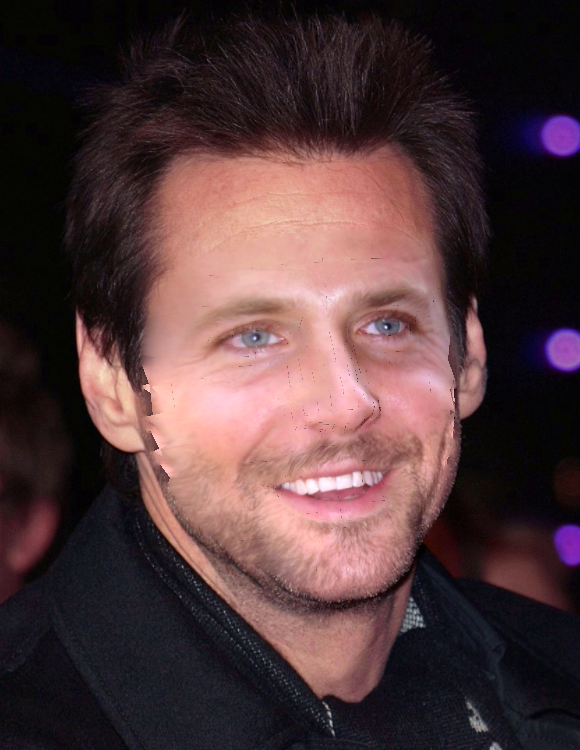

In [38]:
Image.fromarray(seamlessclone)